<a href="https://colab.research.google.com/github/Code-Trees/strixbee/blob/main/Cifar10_resnet_25th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
%autosave 5

Autosaving every 5 seconds


In [4]:
def module_refresh():
    import os
    if 'strixbee' in os.listdir():
        os.system("rm -rf strixbee")
        !git clone https://github.com/Code-Trees/strixbee.git
    else:
        !git clone https://github.com/Code-Trees/strixbee.git

In [5]:
module_refresh()

Cloning into 'strixbee'...
remote: Enumerating objects: 413, done.
remote: Counting objects: 100% (413/413), done.
remote: Compressing objects: 100% (251/251), done.
remote: Total 413 (delta 253), reused 319 (delta 159), pack-reused 0
Receiving objects: 100% (413/413), 448.97 KiB | 15.48 MiB/s, done.
Resolving deltas: 100% (253/253), done.


In [6]:
try:
    #main.py
    import warnings
    warnings.filterwarnings('ignore')

    import numpy as np
    import torch
    import torch.nn.functional as F
    import torch.nn as nn

    from torch.optim import SGD
    from torch.utils.data import DataLoader
    from torch.utils.data.dataset import Dataset
    from torch.optim.lr_scheduler import StepLR

    from torchvision import transforms,datasets

    import numpy as np
    import matplotlib.pyplot as plt
    from torchsummary import summary
    import random
    import seaborn as sns
    import gc

    import albumentations as A
    from albumentations.augmentations.geometric.resize import Resize
    from albumentations.pytorch.transforms import ToTensorV2

    from rf_calc import receptive_field
    import seaborn as sns
    import matplotlib.pyplot as plt
except:
    !pip -q install opencv-python
    !pip -q install -U albumentations
    !pip -q  install opencv-python-headless==4.5.2.52
    !pip -q  install Pillow
    !pip -q  install rf_calc
    !pip -q install torch-lr-finder

    import warnings
    warnings.filterwarnings('ignore')

    import numpy as np
    import torch
    import torch.nn.functional as F
    import torch.nn as nn

    from torch.optim import SGD
    from torch.utils.data import DataLoader
    from torch.utils.data.dataset import Dataset
    from torch.optim.lr_scheduler import StepLR

    from torchvision import transforms,datasets

    import numpy as np
    import matplotlib.pyplot as plt
    from torchsummary import summary
    import random
    import seaborn as sns
    import gc

    import albumentations as A
    from albumentations.augmentations.geometric.resize import Resize
    from albumentations.pytorch.transforms import ToTensorV2

    from rf_calc import receptive_field
    import seaborn as sns
    import matplotlib.pyplot as plt

In [7]:
from strixbee.utils.data_iter import get_data,get_data_stats
from strixbee.utils.data_transforms import AlbumDataset
from strixbee.utils.optimizer_utils import *
from strixbee.utils.train_test import *
from strixbee.utils.gpu import clean_gpu
from strixbee.utils.plots import * 
from strixbee.utils import *
from strixbee.model.custom_layer import *
from strixbee.model import resnet
from strixbee.gradcam import *
from strixbee.gradcam.visualize import VisualizeCam
from strixbee.gradcam.visualize import VisualizeCam

Files already downloaded and verified
Files already downloaded and verified
Train Shape: (50000, 32, 32, 3) Test Shape: (10000, 32, 32, 3) 



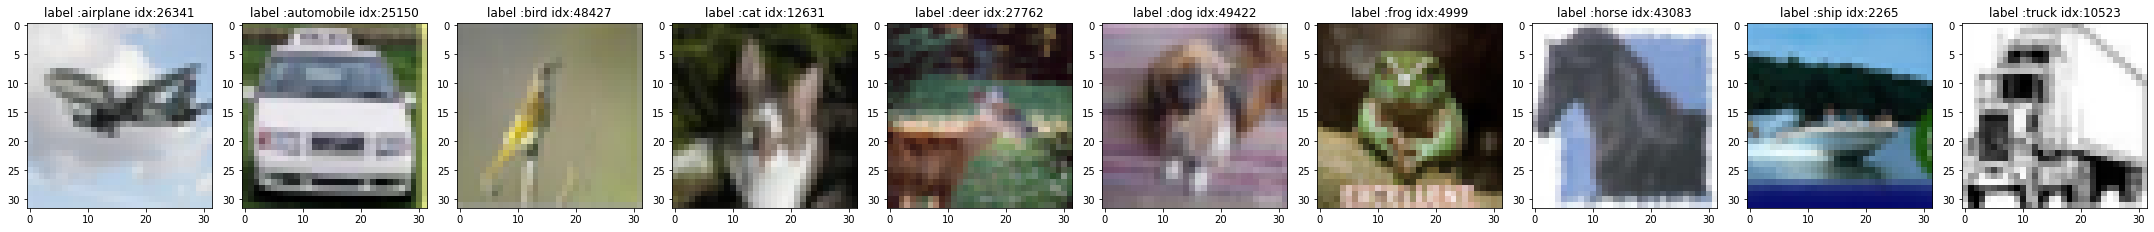

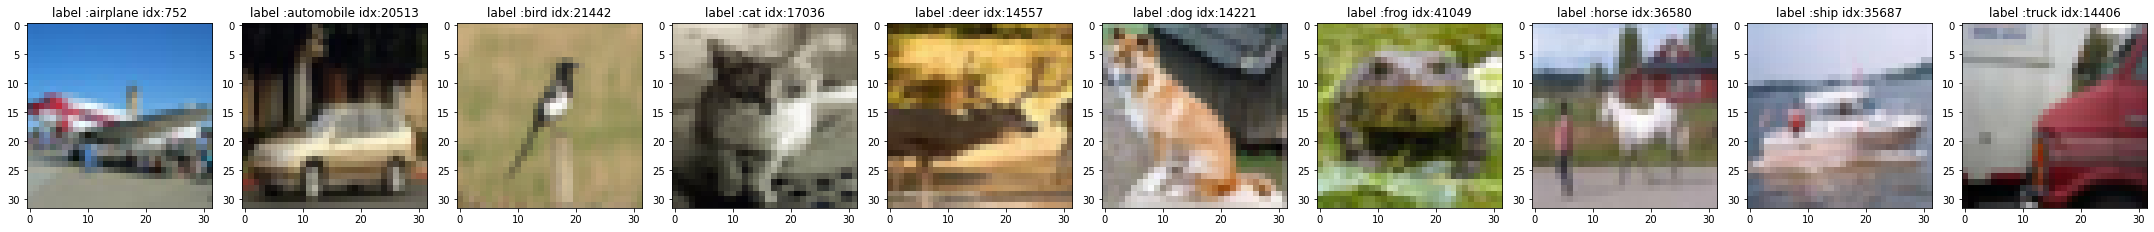

In [8]:
labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
train,test = get_data()
print(f"Train Shape: {train.data.shape} Test Shape: {test.data.shape} \n")
plot_unique_images(train,labels =labels)
plot_unique_images(train,labels =labels)

In [9]:
mean,std  = get_data_stats(train,test,img_norm_typ ='train',plot = False)
print(f"Mean :{mean} , Std :{std}")

Mean :(0.49139967861519745, 0.4821584083946076, 0.44653091444546616) , Std :(0.2470322324632823, 0.24348512800005553, 0.2615878417279641)


<Figure size 1080x360 with 0 Axes>

In [10]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [11]:

def Run_Model(model_class,train_loader,test_loader,epochs , L1 = False):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print (f'running on {device} \n')
    #take input as normal_type ['gbn','bn','gn','ln']
    model = model_class.to(device)
    try:
        print(summary(model,input_size = (3,32,32)))
        pass
    except:
        pass

    # optimizer,scheduler = get_optimizer(model,lr =0.01,scheduler = True,scheduler_type = 'steplr')
    optimizer,scheduler = get_optimizer(model,lr =0.01,scheduler = True,scheduler_type = 'reducelronplateau')
    # optimizer = get_optimizer(model,lr =0.01,scheduler = False,scheduler_type = None)
    # optimizer,scheduler = get_optimizer(model,scheduler = True )
    # optimizer = SGD(params = model.parameters(),lr = 0.01,momentum = 0.9)
    # scheduler = StepLR(optimizer,step_size = 29,gamma = 0.1)

    train_losses = []
    train_accuracy = []
    test_losses =[]
    test_accuracy = []

    for EPOCHS in range(0,epochs):
        if L1 == True:
            train_loss, train_acc = trainning(model,device,train_loader,optimizer,EPOCHS,L1 = True)
            train_losses.append(train_loss)
            train_accuracy.append(train_acc)
        else:
            train_loss, train_acc = trainning(model,device,train_loader,optimizer,EPOCHS)
            train_losses.append(train_loss)
            train_accuracy.append(train_acc)

        test_loss,test_acc = testing(model,device,test_loader,optimizer,EPOCHS)
        print ( "================================================================================" *2)
        test_accuracy.append(test_acc)
        test_losses.append(test_loss)
        
        # scheduler.step()
        scheduler.step(train_loss)
        
        try:
            if (EPOCHS >=5)&(max(test_accuracy[:-1]) < test_accuracy[-1]) & (max(test_accuracy) >= .85):
                checkpoint = {'epoch': EPOCHS + 1,'valid_loss_min': test_losses[-1],'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),} # Export to TorchScript
                torch.save(checkpoint ,'./Model_cifar10.pt') # Save
                print (f"Achieved: {max(test_accuracy)*100}% Test Accuracy !!")
        except:
            print('Model Saving Failed !!')

        print(f"best test accuracy {max(test_accuracy)}\n")
        # print ("LR :{}\n".format(scheduler.get_lr()[0]))
    return model,train_losses, train_accuracy,test_losses,test_accuracy


Files already downloaded and verified
Files already downloaded and verified
running on cuda 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
         

Train ==> Epochs: 0 Batch:  781 loss: 1.6541545391082764 Accuracy: 46.07% : 100%|██████████| 782/782 [00:39<00:00, 19.65it/s]
Test ==> Epochs: 0 Batch:  156 loss: 0.018871971476078032 Accuracy: 58.09% : 100%|██████████| 157/157 [00:02<00:00, 67.18it/s]


Model Saving Failed !!
best test accuracy 0.5809



Train ==> Epochs: 1 Batch:  781 loss: 1.342353105545044 Accuracy: 64.58% : 100%|██████████| 782/782 [00:39<00:00, 19.70it/s]
Test ==> Epochs: 1 Batch:  156 loss: 0.013525024259090423 Accuracy: 70.76% : 100%|██████████| 157/157 [00:02<00:00, 65.72it/s]


best test accuracy 0.7076



Train ==> Epochs: 2 Batch:  781 loss: 0.8946292996406555 Accuracy: 71.20% : 100%|██████████| 782/782 [00:39<00:00, 19.67it/s]
Test ==> Epochs: 2 Batch:  156 loss: 0.010241246554255486 Accuracy: 77.83% : 100%|██████████| 157/157 [00:02<00:00, 66.19it/s]


best test accuracy 0.7783



Train ==> Epochs: 3 Batch:  781 loss: 0.9450383186340332 Accuracy: 75.22% : 100%|██████████| 782/782 [00:39<00:00, 19.69it/s]
Test ==> Epochs: 3 Batch:  156 loss: 0.01102097142636776 Accuracy: 76.43% : 100%|██████████| 157/157 [00:02<00:00, 66.43it/s]


best test accuracy 0.7783



Train ==> Epochs: 4 Batch:  781 loss: 0.5790607333183289 Accuracy: 78.28% : 100%|██████████| 782/782 [00:39<00:00, 19.69it/s]
Test ==> Epochs: 4 Batch:  156 loss: 0.009627467179298401 Accuracy: 79.79% : 100%|██████████| 157/157 [00:02<00:00, 66.74it/s]


best test accuracy 0.7979



Train ==> Epochs: 5 Batch:  781 loss: 0.27670517563819885 Accuracy: 80.65% : 100%|██████████| 782/782 [00:39<00:00, 19.67it/s]
Test ==> Epochs: 5 Batch:  156 loss: 0.00896553828418255 Accuracy: 80.81% : 100%|██████████| 157/157 [00:02<00:00, 67.02it/s]


best test accuracy 0.8081



Train ==> Epochs: 6 Batch:  781 loss: 0.5738657712936401 Accuracy: 82.63% : 100%|██████████| 782/782 [00:39<00:00, 19.65it/s]
Test ==> Epochs: 6 Batch:  156 loss: 0.009716756394505501 Accuracy: 80.58% : 100%|██████████| 157/157 [00:02<00:00, 66.35it/s]


best test accuracy 0.8081



Train ==> Epochs: 7 Batch:  781 loss: 0.5339371562004089 Accuracy: 83.98% : 100%|██████████| 782/782 [00:39<00:00, 19.67it/s]
Test ==> Epochs: 7 Batch:  156 loss: 0.008709899328649044 Accuracy: 82.65% : 100%|██████████| 157/157 [00:02<00:00, 67.00it/s]


best test accuracy 0.8265



Train ==> Epochs: 8 Batch:  781 loss: 0.6350882053375244 Accuracy: 85.81% : 100%|██████████| 782/782 [00:39<00:00, 19.63it/s]
Test ==> Epochs: 8 Batch:  156 loss: 0.008571485124528409 Accuracy: 82.98% : 100%|██████████| 157/157 [00:02<00:00, 65.89it/s]


best test accuracy 0.8298



Train ==> Epochs: 9 Batch:  781 loss: 0.7908580899238586 Accuracy: 87.00% : 100%|██████████| 782/782 [00:39<00:00, 19.66it/s]
Test ==> Epochs: 9 Batch:  156 loss: 0.009350711290538312 Accuracy: 82.25% : 100%|██████████| 157/157 [00:02<00:00, 67.31it/s]


best test accuracy 0.8298



Train ==> Epochs: 10 Batch:  781 loss: 0.3198443055152893 Accuracy: 88.02% : 100%|██████████| 782/782 [00:39<00:00, 19.62it/s]
Test ==> Epochs: 10 Batch:  156 loss: 0.007726094172894955 Accuracy: 85.80% : 100%|██████████| 157/157 [00:02<00:00, 65.48it/s]


Achieved: 85.8% Test Accuracy !!
best test accuracy 0.858



Train ==> Epochs: 11 Batch:  781 loss: 0.668030321598053 Accuracy: 89.10% : 100%|██████████| 782/782 [00:39<00:00, 19.69it/s]
Test ==> Epochs: 11 Batch:  156 loss: 0.01155063973814249 Accuracy: 80.07% : 100%|██████████| 157/157 [00:02<00:00, 65.19it/s]


best test accuracy 0.858



Train ==> Epochs: 12 Batch:  781 loss: 0.13771238923072815 Accuracy: 89.65% : 100%|██████████| 782/782 [00:39<00:00, 19.69it/s]
Test ==> Epochs: 12 Batch:  156 loss: 0.009470616954565048 Accuracy: 83.78% : 100%|██████████| 157/157 [00:02<00:00, 66.35it/s]


best test accuracy 0.858



Train ==> Epochs: 13 Batch:  781 loss: 0.1102939248085022 Accuracy: 90.86% : 100%|██████████| 782/782 [00:39<00:00, 19.71it/s]
Test ==> Epochs: 13 Batch:  156 loss: 0.008251881077140569 Accuracy: 85.52% : 100%|██████████| 157/157 [00:02<00:00, 66.49it/s]


best test accuracy 0.858



Train ==> Epochs: 14 Batch:  781 loss: 0.2461833357810974 Accuracy: 91.34% : 100%|██████████| 782/782 [00:39<00:00, 19.68it/s]
Test ==> Epochs: 14 Batch:  156 loss: 0.009086321285367013 Accuracy: 83.83% : 100%|██████████| 157/157 [00:02<00:00, 66.46it/s]


best test accuracy 0.858



Train ==> Epochs: 15 Batch:  781 loss: 0.056688547134399414 Accuracy: 92.03% : 100%|██████████| 782/782 [00:39<00:00, 19.67it/s]
Test ==> Epochs: 15 Batch:  156 loss: 0.008838590519875287 Accuracy: 84.72% : 100%|██████████| 157/157 [00:02<00:00, 66.94it/s]


best test accuracy 0.858



Train ==> Epochs: 16 Batch:  781 loss: 0.1151067465543747 Accuracy: 92.38% : 100%|██████████| 782/782 [00:39<00:00, 19.70it/s]
Test ==> Epochs: 16 Batch:  156 loss: 0.00835208469852805 Accuracy: 86.41% : 100%|██████████| 157/157 [00:02<00:00, 66.46it/s]


Achieved: 86.41% Test Accuracy !!
best test accuracy 0.8641



Train ==> Epochs: 17 Batch:  781 loss: 0.18872365355491638 Accuracy: 92.95% : 100%|██████████| 782/782 [00:39<00:00, 19.66it/s]
Test ==> Epochs: 17 Batch:  156 loss: 0.008595869619771839 Accuracy: 85.63% : 100%|██████████| 157/157 [00:02<00:00, 65.67it/s]


best test accuracy 0.8641



Train ==> Epochs: 18 Batch:  781 loss: 0.17074677348136902 Accuracy: 93.19% : 100%|██████████| 782/782 [00:39<00:00, 19.71it/s]
Test ==> Epochs: 18 Batch:  156 loss: 0.008224964226037263 Accuracy: 86.52% : 100%|██████████| 157/157 [00:02<00:00, 66.23it/s]


Achieved: 86.52% Test Accuracy !!
best test accuracy 0.8652



Train ==> Epochs: 19 Batch:  781 loss: 0.08934834599494934 Accuracy: 93.78% : 100%|██████████| 782/782 [00:39<00:00, 19.68it/s]
Test ==> Epochs: 19 Batch:  156 loss: 0.007956074705347418 Accuracy: 86.88% : 100%|██████████| 157/157 [00:02<00:00, 67.04it/s]


Achieved: 86.88% Test Accuracy !!
best test accuracy 0.8688



Train ==> Epochs: 20 Batch:  781 loss: 0.328026682138443 Accuracy: 94.04% : 100%|██████████| 782/782 [00:39<00:00, 19.66it/s]
Test ==> Epochs: 20 Batch:  156 loss: 0.008947675667703152 Accuracy: 86.06% : 100%|██████████| 157/157 [00:02<00:00, 67.61it/s]


best test accuracy 0.8688



Train ==> Epochs: 21 Batch:  781 loss: 0.07129739224910736 Accuracy: 94.60% : 100%|██████████| 782/782 [00:39<00:00, 19.71it/s]
Test ==> Epochs: 21 Batch:  156 loss: 0.008265256468206644 Accuracy: 86.91% : 100%|██████████| 157/157 [00:02<00:00, 67.29it/s]


Achieved: 86.91% Test Accuracy !!
best test accuracy 0.8691



Train ==> Epochs: 22 Batch:  781 loss: 0.3661232590675354 Accuracy: 94.68% : 100%|██████████| 782/782 [00:39<00:00, 19.75it/s]
Test ==> Epochs: 22 Batch:  156 loss: 0.010415015242993831 Accuracy: 85.17% : 100%|██████████| 157/157 [00:02<00:00, 66.78it/s]


best test accuracy 0.8691



Train ==> Epochs: 23 Batch:  781 loss: 0.3292670249938965 Accuracy: 94.73% : 100%|██████████| 782/782 [00:39<00:00, 19.72it/s]
Test ==> Epochs: 23 Batch:  156 loss: 0.009562042263895273 Accuracy: 85.58% : 100%|██████████| 157/157 [00:02<00:00, 65.74it/s]


best test accuracy 0.8691



Train ==> Epochs: 24 Batch:  781 loss: 0.05883856117725372 Accuracy: 95.07% : 100%|██████████| 782/782 [00:39<00:00, 19.71it/s]
Test ==> Epochs: 24 Batch:  156 loss: 0.009564376594126225 Accuracy: 85.71% : 100%|██████████| 157/157 [00:02<00:00, 66.97it/s]


best test accuracy 0.8691



Train ==> Epochs: 25 Batch:  781 loss: 0.12932531535625458 Accuracy: 95.19% : 100%|██████████| 782/782 [00:39<00:00, 19.74it/s]
Test ==> Epochs: 25 Batch:  156 loss: 0.008706001898646355 Accuracy: 86.97% : 100%|██████████| 157/157 [00:02<00:00, 67.02it/s]


Achieved: 86.97% Test Accuracy !!
best test accuracy 0.8697



Train ==> Epochs: 26 Batch:  781 loss: 0.4900188446044922 Accuracy: 95.60% : 100%|██████████| 782/782 [00:39<00:00, 19.72it/s]
Test ==> Epochs: 26 Batch:  156 loss: 0.008284545706957578 Accuracy: 86.73% : 100%|██████████| 157/157 [00:02<00:00, 67.54it/s]


best test accuracy 0.8697



Train ==> Epochs: 27 Batch:  781 loss: 0.0984756201505661 Accuracy: 95.74% : 100%|██████████| 782/782 [00:39<00:00, 19.74it/s]
Test ==> Epochs: 27 Batch:  156 loss: 0.008398063907027244 Accuracy: 86.70% : 100%|██████████| 157/157 [00:02<00:00, 67.24it/s]


best test accuracy 0.8697



Train ==> Epochs: 28 Batch:  781 loss: 0.21157027781009674 Accuracy: 95.63% : 100%|██████████| 782/782 [00:39<00:00, 19.73it/s]
Test ==> Epochs: 28 Batch:  156 loss: 0.008953511856123805 Accuracy: 86.88% : 100%|██████████| 157/157 [00:02<00:00, 67.16it/s]


best test accuracy 0.8697



Train ==> Epochs: 29 Batch:  781 loss: 0.08640766143798828 Accuracy: 96.04% : 100%|██████████| 782/782 [00:39<00:00, 19.75it/s]
Test ==> Epochs: 29 Batch:  156 loss: 0.007912532696127891 Accuracy: 87.29% : 100%|██████████| 157/157 [00:02<00:00, 66.13it/s]


Achieved: 87.29% Test Accuracy !!
best test accuracy 0.8729



Train ==> Epochs: 30 Batch:  781 loss: 0.15268932282924652 Accuracy: 96.29% : 100%|██████████| 782/782 [00:39<00:00, 19.73it/s]
Test ==> Epochs: 30 Batch:  156 loss: 0.00889834378361702 Accuracy: 87.04% : 100%|██████████| 157/157 [00:02<00:00, 65.75it/s]


best test accuracy 0.8729



Train ==> Epochs: 31 Batch:  781 loss: 0.1761639565229416 Accuracy: 96.26% : 100%|██████████| 782/782 [00:39<00:00, 19.71it/s]
Test ==> Epochs: 31 Batch:  156 loss: 0.008770329866558313 Accuracy: 87.07% : 100%|██████████| 157/157 [00:02<00:00, 66.80it/s]


best test accuracy 0.8729



Train ==> Epochs: 32 Batch:  781 loss: 0.019169244915246964 Accuracy: 96.42% : 100%|██████████| 782/782 [00:39<00:00, 19.74it/s]
Test ==> Epochs: 32 Batch:  156 loss: 0.008692971796542406 Accuracy: 87.22% : 100%|██████████| 157/157 [00:02<00:00, 66.89it/s]


best test accuracy 0.8729



Train ==> Epochs: 33 Batch:  781 loss: 0.15191252529621124 Accuracy: 96.44% : 100%|██████████| 782/782 [00:39<00:00, 19.70it/s]
Test ==> Epochs: 33 Batch:  156 loss: 0.00931205267701298 Accuracy: 86.64% : 100%|██████████| 157/157 [00:02<00:00, 65.97it/s]


best test accuracy 0.8729



Train ==> Epochs: 34 Batch:  781 loss: 0.06256980448961258 Accuracy: 96.65% : 100%|██████████| 782/782 [00:39<00:00, 19.74it/s]
Test ==> Epochs: 34 Batch:  156 loss: 0.008625702284276485 Accuracy: 87.26% : 100%|██████████| 157/157 [00:02<00:00, 65.58it/s]


best test accuracy 0.8729



Train ==> Epochs: 35 Batch:  781 loss: 0.016993403434753418 Accuracy: 96.82% : 100%|██████████| 782/782 [00:39<00:00, 19.65it/s]
Test ==> Epochs: 35 Batch:  156 loss: 0.008835368241369724 Accuracy: 87.36% : 100%|██████████| 157/157 [00:02<00:00, 66.02it/s]


Achieved: 87.36% Test Accuracy !!
best test accuracy 0.8736



Train ==> Epochs: 36 Batch:  781 loss: 0.014127550646662712 Accuracy: 96.80% : 100%|██████████| 782/782 [00:39<00:00, 19.73it/s]
Test ==> Epochs: 36 Batch:  156 loss: 0.009057367752864956 Accuracy: 87.05% : 100%|██████████| 157/157 [00:02<00:00, 66.21it/s]


best test accuracy 0.8736



Train ==> Epochs: 37 Batch:  781 loss: 0.13304655253887177 Accuracy: 97.06% : 100%|██████████| 782/782 [00:39<00:00, 19.75it/s]
Test ==> Epochs: 37 Batch:  156 loss: 0.008597670609503984 Accuracy: 87.56% : 100%|██████████| 157/157 [00:02<00:00, 66.49it/s]


Achieved: 87.56% Test Accuracy !!
best test accuracy 0.8756



Train ==> Epochs: 38 Batch:  781 loss: 0.0009483512258157134 Accuracy: 97.06% : 100%|██████████| 782/782 [00:39<00:00, 19.73it/s]
Test ==> Epochs: 38 Batch:  156 loss: 0.008455470763891935 Accuracy: 87.88% : 100%|██████████| 157/157 [00:02<00:00, 64.30it/s]


Achieved: 87.88% Test Accuracy !!
best test accuracy 0.8788



Train ==> Epochs: 39 Batch:  781 loss: 0.32748159766197205 Accuracy: 97.23% : 100%|██████████| 782/782 [00:39<00:00, 19.70it/s]
Test ==> Epochs: 39 Batch:  156 loss: 0.00930766455605626 Accuracy: 87.68% : 100%|██████████| 157/157 [00:02<00:00, 66.99it/s]


best test accuracy 0.8788



Train ==> Epochs: 40 Batch:  781 loss: 0.07661159336566925 Accuracy: 97.10% : 100%|██████████| 782/782 [00:39<00:00, 19.74it/s]
Test ==> Epochs: 40 Batch:  156 loss: 0.008619541765749455 Accuracy: 87.57% : 100%|██████████| 157/157 [00:02<00:00, 67.08it/s]


best test accuracy 0.8788



Train ==> Epochs: 41 Batch:  781 loss: 0.10585866868495941 Accuracy: 97.42% : 100%|██████████| 782/782 [00:39<00:00, 19.75it/s]
Test ==> Epochs: 41 Batch:  156 loss: 0.008463958773761987 Accuracy: 87.76% : 100%|██████████| 157/157 [00:02<00:00, 65.17it/s]


best test accuracy 0.8788



Train ==> Epochs: 42 Batch:  781 loss: 0.4880901575088501 Accuracy: 97.39% : 100%|██████████| 782/782 [00:39<00:00, 19.71it/s]
Test ==> Epochs: 42 Batch:  156 loss: 0.009001449248194694 Accuracy: 88.15% : 100%|██████████| 157/157 [00:02<00:00, 65.51it/s]


Achieved: 88.14999999999999% Test Accuracy !!
best test accuracy 0.8815



Train ==> Epochs: 43 Batch:  781 loss: 0.024749329313635826 Accuracy: 97.43% : 100%|██████████| 782/782 [00:39<00:00, 19.73it/s]
Test ==> Epochs: 43 Batch:  156 loss: 0.00870248468220234 Accuracy: 87.83% : 100%|██████████| 157/157 [00:02<00:00, 67.25it/s]


best test accuracy 0.8815



Train ==> Epochs: 44 Batch:  781 loss: 0.13638798892498016 Accuracy: 97.54% : 100%|██████████| 782/782 [00:39<00:00, 19.72it/s]
Test ==> Epochs: 44 Batch:  156 loss: 0.008956539171934128 Accuracy: 87.36% : 100%|██████████| 157/157 [00:02<00:00, 66.31it/s]


best test accuracy 0.8815



Train ==> Epochs: 45 Batch:  781 loss: 0.1289391815662384 Accuracy: 97.58% : 100%|██████████| 782/782 [00:39<00:00, 19.73it/s]
Test ==> Epochs: 45 Batch:  156 loss: 0.00840829723663628 Accuracy: 87.66% : 100%|██████████| 157/157 [00:02<00:00, 66.24it/s]


best test accuracy 0.8815



Train ==> Epochs: 46 Batch:  781 loss: 0.021817531436681747 Accuracy: 97.78% : 100%|██████████| 782/782 [00:39<00:00, 19.64it/s]
Test ==> Epochs: 46 Batch:  156 loss: 0.00958844260238111 Accuracy: 87.66% : 100%|██████████| 157/157 [00:02<00:00, 66.91it/s]


best test accuracy 0.8815



Train ==> Epochs: 47 Batch:  781 loss: 0.29310303926467896 Accuracy: 97.80% : 100%|██████████| 782/782 [00:39<00:00, 19.70it/s]
Test ==> Epochs: 47 Batch:  156 loss: 0.008424654204398394 Accuracy: 87.85% : 100%|██████████| 157/157 [00:02<00:00, 65.05it/s]


best test accuracy 0.8815



Train ==> Epochs: 48 Batch:  781 loss: 0.006261824164539576 Accuracy: 97.94% : 100%|██████████| 782/782 [00:39<00:00, 19.76it/s]
Test ==> Epochs: 48 Batch:  156 loss: 0.00875981834307313 Accuracy: 87.97% : 100%|██████████| 157/157 [00:02<00:00, 65.26it/s]


best test accuracy 0.8815



Train ==> Epochs: 49 Batch:  781 loss: 0.1515026092529297 Accuracy: 97.69% : 100%|██████████| 782/782 [00:39<00:00, 19.67it/s]
Test ==> Epochs: 49 Batch:  156 loss: 0.009216323636472226 Accuracy: 87.62% : 100%|██████████| 157/157 [00:02<00:00, 67.00it/s]


best test accuracy 0.8815



<Figure size 1080x360 with 0 Axes>

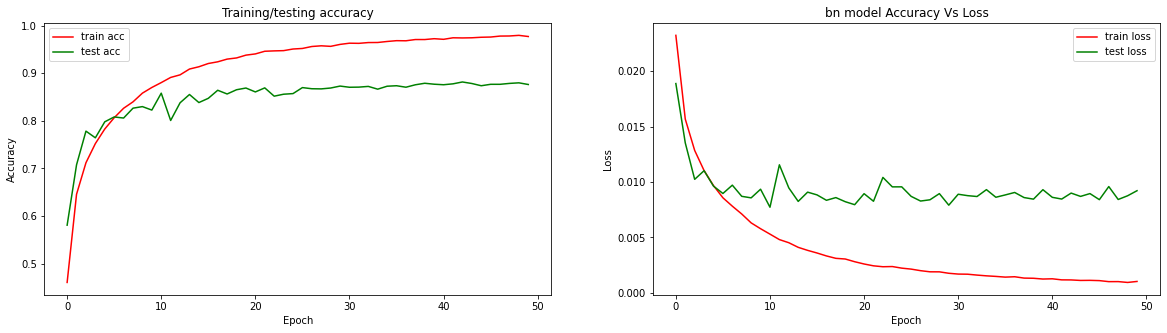

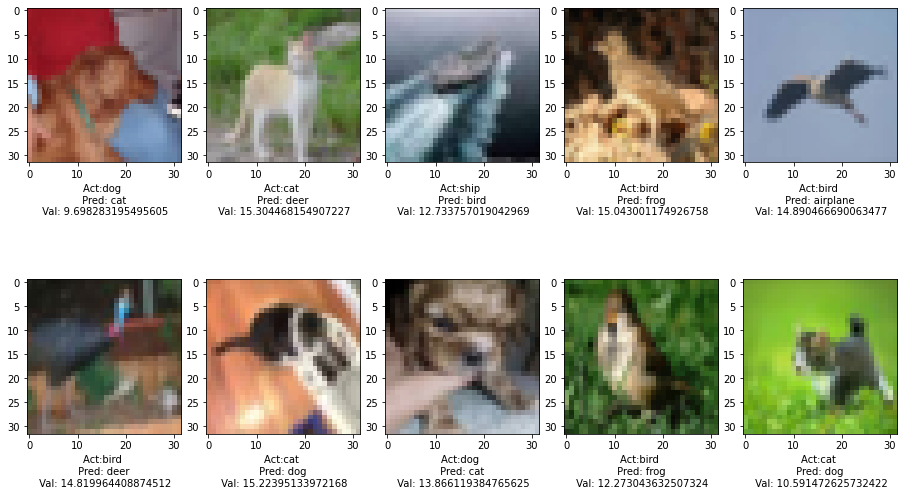

In [12]:
if __name__ == "__main__":
    batch_size = 64
    epochs =50

    _=torch.manual_seed(1)
    if torch.cuda.is_available():
        _=torch.cuda.manual_seed(1)

    train,test = get_data()
    #take input as normal_type ['gbn','bn','gn','ln']
    # To Un Normalize the test data
    mean,std  = get_data_stats(test,train,img_norm_typ ='train',plot = False)
    
    # # Advanced Normalization
    train_transform =A.Compose([A.Resize(32,32),
                                A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
                                A.ShiftScaleRotate(shift_limit=0.0,scale_limit =0.1,rotate_limit=7 ,always_apply=False),
                                A.CoarseDropout(always_apply = False,max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=mean, mask_fill_value = None),
                                
                                ToTensorV2(transpose_mask =False),
                                 ])      
    test_transform = A.Compose([A.Resize(32,32),
                                 A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
                               ToTensorV2(transpose_mask =False), ])
    # #basic Normalization
    # train_transform =A.Compose([A.Resize(32,32),
    #                             A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
    #                             ToTensorV2(transpose_mask =False),
    #                             ])      
    # test_transform = A.Compose([A.Resize(32,32),
    #                             A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
    #                             ToTensorV2(transpose_mask =False,),
    #                             ])

    train_alb = AlbumDataset(train,train_transform)
    test_alb = AlbumDataset(test,test_transform)

    args = {'pin_memory':True,'num_workers':4} if torch.cuda.is_available() else {}
    train_loader = DataLoader(train_alb,batch_size=batch_size,shuffle = True,**args)
    test_loader = DataLoader(test_alb,batch_size=batch_size,**args)
    # ['gbn','bn','gn','ln']
    try_type = ['bn']
    for norm_type in try_type:

        model_class =resnet.ResNet18()
        
        # model_class = model
        model,train_losses, train_accuracy,test_losses,test_accuracy = Run_Model(model_class,train_loader,test_loader,epochs =epochs)

        plot_acc_loss(norm_type ,train_accuracy,train_losses,test_accuracy,test_losses)
        clean_gpu()

        wrong_images,wrong_labels,right_labels = print_wrong_image(model,test_loader,mean,std,2,5)
        clean_gpu()

        num_img = 20
        correct_pred_imgs = []
        count = 0

        for i in range(num_img):
            correct_pred_imgs.append(torch.as_tensor(random.choice(wrong_images)))

        target_layers = ["layer1","layer2","layer3","layer4"]
        viz_cam = VisualizeCam(model,[labels[i] for i in range(0,10)], target_layers)
        viz_cam(torch.stack(correct_pred_imgs), target_layers, metric="worng")

In [23]:
# #model Designing 

# model = Cifar10Net1(dropout_val = 0.00,norm_type = norm_type)
# model = model.to(device)

# model.train()

# train_loader 
# device = 'cuda' if torch.cuda.is_available() else "cpu"
# for index_id,(data,target) in enumerate(train_loader):
#     data,target = data ,target
#     # optimizer.zero_grad()x
#     break

# # output.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '3 is cat')

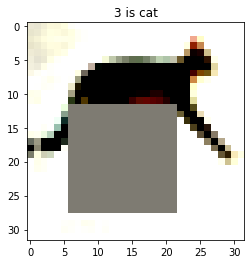

In [36]:
# a= 7
# plt.imshow(np.transpose(data[a],(1,2,0)))
# plt.title(f"{target[a].item()} is {labels[target[a].item()]}")